# Спасибо ребятам из команды Sokolov и Golobokov за baseline

# 1. Загрузка необходимых библиотек

In [413]:
# Импортируем необходимые библиотеки
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, OrdinalEncoder, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, \
                            plot_confusion_matrix, precision_recall_curve, auc, plot_precision_recall_curve, average_precision_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

# Загрузка данных Kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

# Загружаем дополнительные функции

# Plot Boxplots
def plot_outliers(df, width=20, height=10):
    '''
    df - Pandas DataFrame
    width - Figure width
    height - Figure height
    '''
    fig = plt.figure(figsize=(width, height))
    sns.boxplot(x="variable", y="value", data=pd.melt(df))
    plt.show()
    

# Plot BoxPlots compare to target class
def plot_boxplots(df, columns, target, nrows=2, ncols=2, figsize=(15,15)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    plt.subplots_adjust(wspace = 0.5)
    axes = axes.flatten()
    for i in range(len(columns)):
        sns.boxplot(x="default", y=columns[i], data=df, orient = 'v', ax=axes[i], showfliers=True)
        
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, use_abs=True, target=None, filter_target=False):
    '''
    df - Pandas DataFrame
    n - number of return values
    use_abs - use absolute numbers
    target - feature name to return
    filter_target - use feature filter
    '''
    
    if use_abs:
        au_corr = df.corr().abs().unstack()
    else:
        au_corr = df.corr().unstack()
        
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    if filter_target and target is not None:
        return au_corr.filter(like=target, axis=0)[0:n]
    
    return au_corr[0:n]


# Посчитаем важность признаков при помощи однофакторного дисперсионного анализа (ANOVA)
def plot_fclassif(df, columns, target):
    '''
    sklean.feature_selection.f_classif wrapper
    ------------------------------------------
    df - Pandas DataFrame
    columns - numerical features
    target - Our target feature
    '''
    
    if df is not None and columns is not None and target is not None:
        imp_num = pd.Series(f_classif(df[columns], df[target])[0], index = columns)
        imp_num.sort_values(inplace = True)
        imp_num.plot(kind = 'barh')
    else:
        raise Exception('Fill params!')


def plot_mutual_info_classif(df, columns, target):
    '''
    sklean.feature_selection.mutual_info_classif
    ------------------------------------------
    df - Pandas DataFrame
    columns - binary, categorical features
    target - Our target feature
    '''
    if df is not None and columns is not None and target is not None:
        imp_cat = pd.Series(mutual_info_classif(df[columns], df[target],
                                            discrete_features =True), index = columns)
        imp_cat.sort_values(inplace = True)
        imp_cat.plot(kind = 'barh')
    else:
        raise Exception('Fill params!')
        
# Отрисовать ROC кривую
def roc_auc_plot(y_true, y_pred_proba):
    '''
    Функция считает AUC и отрисовывает ROC кривую:
        y_true - истинное значение класса
        y_pred_proba - предсказанная вероятность класса [:, 1]
    '''
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.title('ROC AUC = %0.3f' % roc_auc, fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15, loc = 'lower right')

# Выводим распределение переменной и ее логарифма
def plot_dist_log(df, column, nrows=1, ncols=2, figsize=(15,15)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    plt.subplots_adjust(wspace = 0.5)
    axes = axes.flatten()
    axes[0].title.set_text(column)
    axes[1].title.set_text('np.log('+column+')')
    sns.distplot(df[column], ax=axes[0], axlabel=False, kde=False)
    sns.distplot(np.log(df[column] + 1), ax=axes[1], axlabel=False, kde=False)
    fig.suptitle(f'Распределение признака {column} и np.log({column})', fontsize=16, y=1.12)
    
    # Выводим дополнительную информацию о признаке
    feature_info = dict(count=df[column].count(), nan=df[column].isnull().sum(), 
                    min=df[column].min(), max=df[column].max(), median=df[column].median(), mean=df[column].mean())

    fi = pd.Series(feature_info)
    p = pd.DataFrame(fi, columns=[column])

    display(p)

# Выводим метрики модели
def show_model_metrics(y_true, y_pred, y_probs):
    print(f'f1_score: {f1_score(y_true, y_pred)}')
    print(f'precision_score: {precision_score(y_true, y_pred)}')
    print(f'recall_score: {recall_score(y_true, y_pred)}')
    print(f'roc_auc: {roc_auc_score(y_true, y_probs)}')
    
    
# Выводим PRC-AUC
def plot_prc_auc(model, X, y, y_prob):
    average_precision = average_precision_score(y, y_prob)
    disp = plot_precision_recall_curve(model, X, y)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
# Нарисовать кросс-валидацию
def plot_crossval_score(cross_val, metric, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    sns.lineplot(data=cross_val, x=range(len(cross_val['score_time'])), y="test_score", legend='full', label='тестовая выборка')
    sns.lineplot(data=cross_val, x=range(len(cross_val['score_time'])), y="train_score", legend='full', label='тренировочная выборка')
    sns.lineplot(data=cross_val, x=range(len(cross_val['score_time'])), y=np.mean(cross_val['test_score']), label='среднее значение на тесте')
    sns.lineplot(data=cross_val, x=range(len(cross_val['score_time'])), y=np.mean(cross_val['train_score']), legend='full', label='среднее значение на трейне')
    plt.xlabel("Номер фолда")
    plt.ylabel(metric)
    plt.title(f"Кросс-валидация по ROC-AUC (KFold={len(cross_val['score_time'])})")

def prepare_data(df):
    # Готовим данные для обучения модели
    train_data = df[df.Train == 1].drop(['Train'], axis=1)
    test_data = df[df.Train == 0].drop(['Train'], axis=1)

    y = train_data.default.values
    X = train_data.drop(['default'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    return X_train, X_test, y_train, y_test


# Удаляем выбросы в датасете 
def remove_outliers_irq_dataset(df, iqr_detect=1.5):
    '''
    df - Pandas DataFrame
    iqr_detect - IQR to detect and filter outliers. Default: 1.5 
    '''
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    return df[~((df < (Q1 - iqr_detect * IQR)) |(df > (Q3 + iqr_detect * IQR))).any(axis=1)]

# Удаляем выбросы по конкретному признаку
def remove_outliers_iqr_column(df_in, col_name):
    '''
    df_in - Pandas DataFrame
    col_name - DataFrame column to detect outliers
    '''
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    
    return df_out

# Загузка данных с обработкой признаков
def load_data(fill_na='popular', preprocess=False, drop_outliers=False, outliers_column=None, log_numerical=True):
    '''load_data - загружает данных и возвращает обработанный Pandas DataFrame
        fill_na - как заполнять пропущенные значения [mean, mode, drop]
        preprocess - выполнять или нет ручную обработку данных [False если используется pipeline]
        drop_outliers - удалять выбросы или нет 
        log_numerical - логарифмировать числовые признаки или нет
    '''
    df_train = pd.read_csv(PATH_to_file+'train.csv')
    df_test = pd.read_csv(PATH_to_file+'test.csv')
    
    df_train['Train'] = 1 # трэйн
    df_test['Train'] = 0 # тест

    df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
    
    # внесем данные из резюме в списки 
    time_cols = ['app_date']
    # бинарные переменные
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default_peak', 'normal_age']
    # категориальные переменные
    cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
    # числовые переменные
    num_cols = ['client_id', 'age','decline_app_cnt','score_bki','bki_request_cnt','income','days_between_firstdate', 'mean_region_bki'] # days_between_firstdate - признак добавим позже, как разницу между
       
    # Логарифмируем переменные
    if log_numerical:
        df['age'] = np.log(df['age'] + 1)
        df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)
        df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
        df['income'] = np.log(df['income'] + 1)
    
    # Дата
    df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
    
    # Посмотрим на максимальное и минимальное значение
    start_date = df.app_date.min()
    end_date = df.app_date.max()
    
    # Создадим новый признак - номер дня от минимальной даты
    df['days_between_firstdate'] = (df.app_date - start_date).dt.days.astype('int')
    
    # Признак, когда дефолт идет на спад
    df['default_peak'] = (df.days_between_firstdate > 90).astype('int')
    
    # Средний score_bki по региону
#     mean_score_bki = df.groupby('region_rating')['score_bki'].mean().to_dict()
#     df['mean_region_bki'] = df.apply(lambda x: x.score_bki / mean_score_bki[x.region_rating], axis=1)
    
    # Обычно благоприятный возраст для кредита 30-40 лет
    df['normal_age'] = ((df.age >= 30) & (df.age <= 40)).astype('int')
    
    # Ручная обработка данных
    if preprocess:
        labelEncoder = LabelEncoder()

        # Закодируем бинарные признаки
        for column in bin_cols:
            df[column] = labelEncoder.fit_transform(df[column])

        # Закодируем признак education, но сперва заполним пропуски самым частым значением
        # Заполним пропуски
        if fill_na in ['mean', 'mode', 'drop']:
            if fill_na == 'mean':
                df.education = df.education.fillna(df.education.value_counts()
                                [df.education.value_counts() == int(df.education.value_counts().median())].index[0])
            elif fill_na == 'mode':
                df.education = df.education.fillna(df.education.mode()[0])
            elif fill_na == 'drop':
                df = df.dropna(axis=0)
        else:
            df.education = df.education.fillna('SCH')

        # Закодируем признак образования
        df.education = labelEncoder.fit_transform(df.education)

        # Категориальные признаки в дамми переменные
        df = pd.get_dummies(df, columns=cat_cols)
        
    df.drop('app_date', axis=1, inplace=True)
    
    # Удаляем выбросы
    if drop_outliers and outliers_column is not None:
        return remove_outliers_iqr_column(df, outliers_column)
    
    return df   

# Пайплайн обработки данных
def prepare_data_pipeline(scaler='standard', polynomial_features=False, polynomial_n=2):
    # бинарные переменные
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default_peak', 'normal_age']
    # категориальные переменные
    cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
    # числовые переменные
    num_cols = ['client_id', 'age','decline_app_cnt','score_bki','bki_request_cnt','income','days_between_firstdate'] # days_between_firstdate - признак добавим позже, как разницу между
    # Фичи для полиномизации
    poly_cols = ['decline_app_cnt', 'score_bki', 'bki_request_cnt']
    
    bin_transformer = make_pipeline(OrdinalEncoder())
    cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent', missing_values=np.nan), OrdinalEncoder(), OneHotEncoder())
    poly_transformer = make_pipeline(PolynomialFeatures(polynomial_n))
    
    if scaler == 'standard':
        num_transformer = make_pipeline(StandardScaler())
    elif scaler == 'robust':
        num_transformer = make_pipeline(RobustScaler())
    elif scaler == 'minmax':
        num_transformer = make_pipeline(MinMaxScaler())
    else:
        num_transformer = make_pipeline(StandardScaler())
        
    if polynomial_features:
        transformers = [
                        ('bin', bin_transformer, bin_cols),
                        ('cat', cat_transformer, cat_cols),
                        ('num', num_transformer, num_cols),
                        ('poly', poly_transformer, poly_cols)
        ]
    else:
        transformers = [
                        ('bin', bin_transformer, bin_cols),
                        ('cat', cat_transformer, cat_cols),
                        ('num', num_transformer, num_cols),                    
        ]
    
    return ColumnTransformer(transformers=transformers, remainder='passthrough')
    

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [408]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('26/10/2020')

# 2. Загрузка данных

In [409]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head())
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head())

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [410]:
# Выполняем объединение датасетов в один
df_train['Train'] = 1 # трэйн
df_test['Train'] = 0 # тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [412]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,normal_age
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1,0


# 3. Выполняем EDA

Описания полей датасета

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [287]:
# Посмотрим дополнительную информацию по датасету

print(f'Размер обучающей выборки: {df_train.shape}, размер тестовой выборки: {df_test.shape}')

# Количество уникальных значений
for column in df.columns:
    print(f'{column} = {len(df[column].unique())}')

Размер обучающей выборки: (73799, 20), размер тестовой выборки: (36349, 19)
client_id = 110148
app_date = 120
education = 6
sex = 2
age = 52
car = 2
car_type = 2
decline_app_cnt = 24
good_work = 2
score_bki = 102618
bki_request_cnt = 40
region_rating = 7
home_address = 3
work_address = 3
income = 1207
sna = 4
first_time = 4
foreign_passport = 2
default = 3
Train = 2


По данным видим, что у нас имеется 1 признак - временной, 5 бинарных, 6 категориальных и 6 числовых.

In [288]:
# внесем данные из резюме в списки 
time_cols = ['app_date']
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные
num_cols = ['client_id', 'age','decline_app_cnt','score_bki','bki_request_cnt','income','days_between_firstdate'] # days_between_firstdate - признак добавим позже, как разницу между минимальным app_date и app_date 

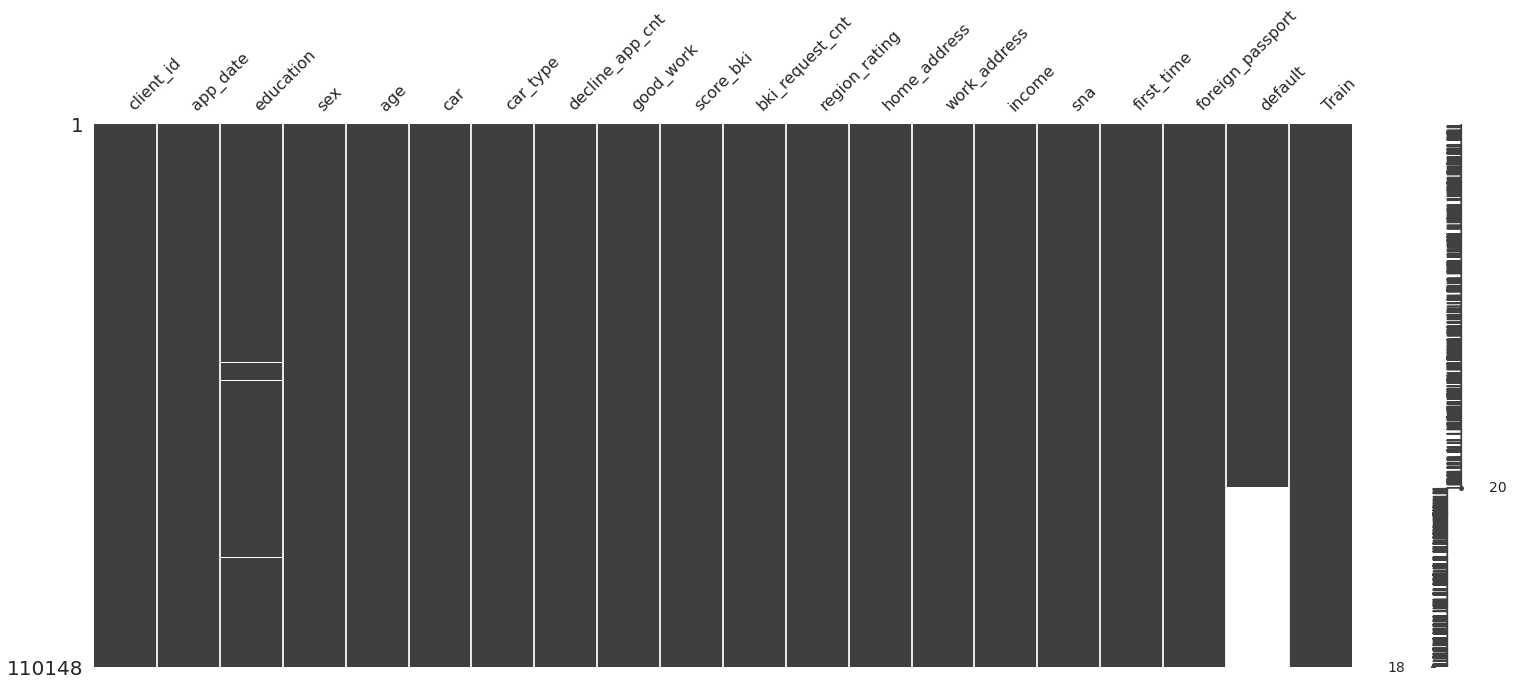

In [289]:
# Посмотрим на пропуски
import missingno as msno
msno.matrix(df)

0.0    64427
1.0     9372
Name: default, dtype: int64

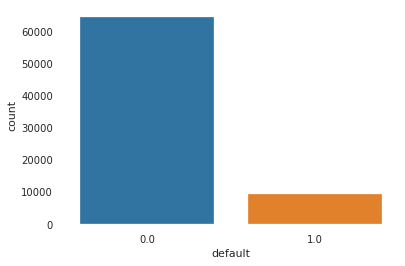

In [290]:
# Посмотрим на нашу целевую переменную
sns.countplot(x='default', data=df)
display(df.default.value_counts())

Видим,что у нас сильно несбалансированная выборка, что может привести к неудовлетворительным результатам при обучении логистической регрессии.

# 4 Посмотрим на признаки

## age

,age
count,73799.000000
nan,0.000000
min,21.000000
max,72.000000
median,37.000000
mean,39.280641


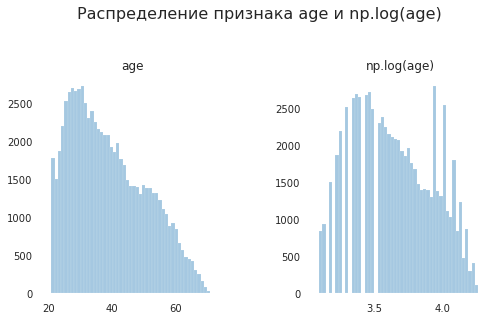

In [291]:
plot_dist_log(df[df.Train==1], 'age', figsize=(8,4))

**age** - берем логарифмированный признак в работу

In [292]:
df['age'] = np.log(df['age'] + 1)

## decline_app_cnt

,decline_app_cnt
count,73799.000000
nan,0.000000
min,0.000000
max,33.000000
median,0.000000
mean,0.275749


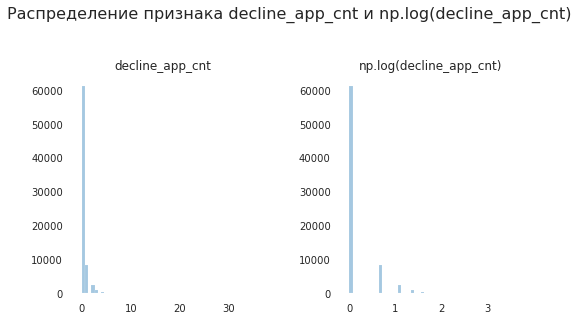

In [293]:
#'age','decline_app_cnt','score_bki','bki_request_cnt','income'
plot_dist_log(df[df.Train==1], 'decline_app_cnt', figsize=(8,4))


**decline_app_cnt**: логарифмирование особо не помогло, тем не менее оставим его в модели.

In [294]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

## score_bki

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,score_bki
count,73799.000000
nan,0.000000
min,-3.624586
max,0.199773
median,-1.920823
mean,-1.904724


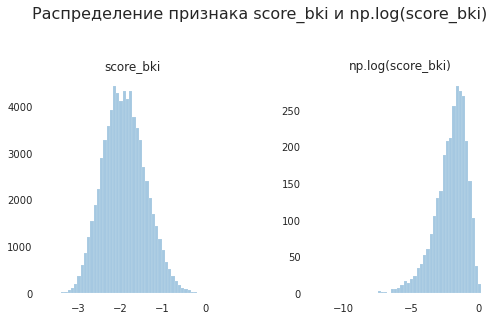

In [295]:
plot_dist_log(df[df.Train==1], 'score_bki', figsize=(8,4))

**score_bki** распределение изначально нормальное. Логарифмирование смещает распределение вправо. Оставим признак как есть.

## bki_request_cnt

,bki_request_cnt
count,73799.000000
nan,0.000000
min,0.000000
max,53.000000
median,1.000000
mean,2.000339


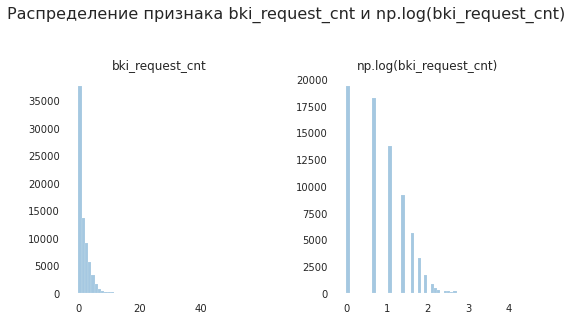

In [296]:
plot_dist_log(df[df.Train==1], 'bki_request_cnt', figsize=(8,4))

**bki_request_cnt** оставим логарифмированное распределение.

In [297]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

## income

,income
count,73799.000000
nan,0.000000
min,1000.000000
max,1000000.000000
median,30000.000000
mean,41099.775417


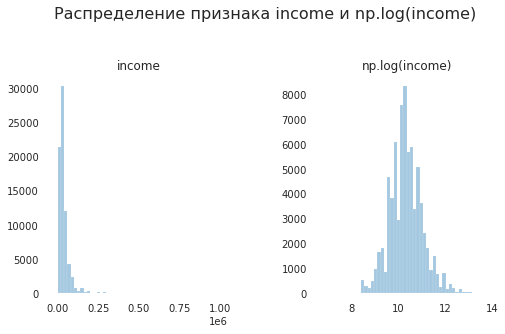

In [298]:
plot_dist_log(df[df.Train==1], 'income', figsize=(8,4))

**income** логарифмированное распределение стало похоже на нормальное. Оставим в этом виде.

In [299]:
df['income'] = np.log(df['income'] + 1)

## Категориальные признаки
Посмотрим на 'education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time'

## education

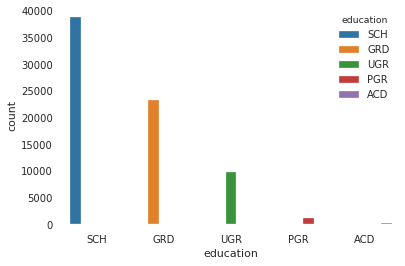

In [300]:
sns.countplot(x='education', data=df[df.Train==1], hue='education')

## region_rating

,region_rating
count,73799.000000
nan,0.000000
min,20.000000
max,80.000000
median,50.000000
mean,56.725701


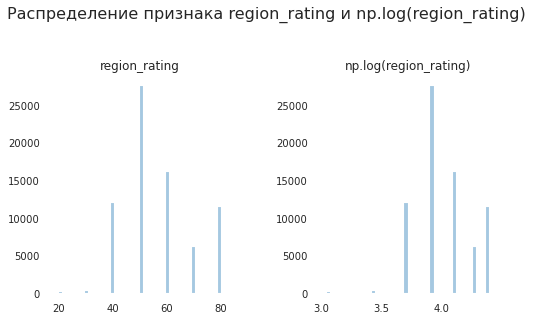

In [301]:
plot_dist_log(df[df.Train==1], 'region_rating', figsize=(8,4))

**region_rating** распределение похоже на нормальное. Посмотрим как модель поведет себя при обучение и примем решение о логарифмировании.

## home_address

,home_address
count,73799.000000
nan,0.000000
min,1.000000
max,3.000000
median,2.000000
mean,1.575509


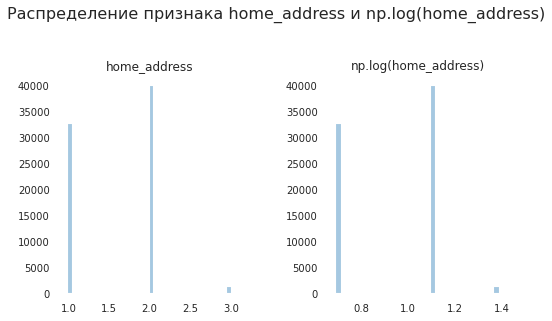

In [302]:
plot_dist_log(df[df.Train==1], 'home_address', figsize=(8,4))

**home_address** имеет 3 категории. Оставляем как есть.

## work_address

,work_address
count,73799.00000
nan,0.00000
min,1.00000
max,3.00000
median,3.00000
mean,2.49628


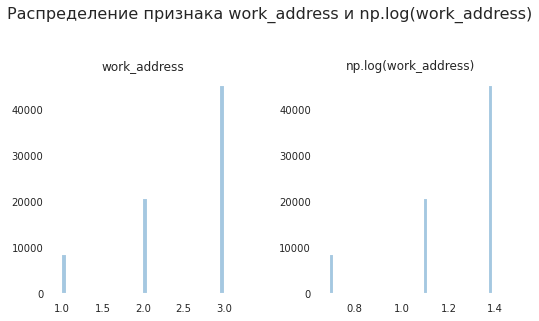

In [303]:
plot_dist_log(df[df.Train==1], 'work_address', figsize=(8,4))

**work_address** аналогично home_address

## sna

,sna
count,73799.00000
nan,0.00000
min,1.00000
max,4.00000
median,1.00000
mean,1.73333


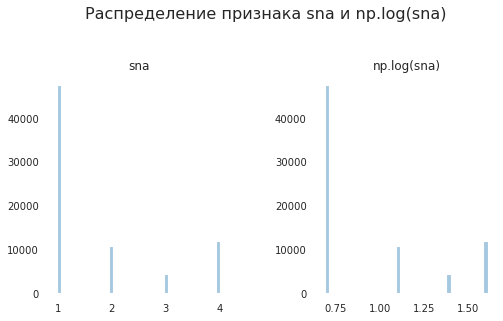

In [304]:
plot_dist_log(df[df.Train==1], 'sna', figsize=(8,4))

**sna** видим, что распределение смещено вправо. Логарифмирование не вносит значительных изменений. Оставим как есть.  

## first_time

,first_time
count,73799.000000
nan,0.000000
min,1.000000
max,4.000000
median,3.000000
mean,2.765458


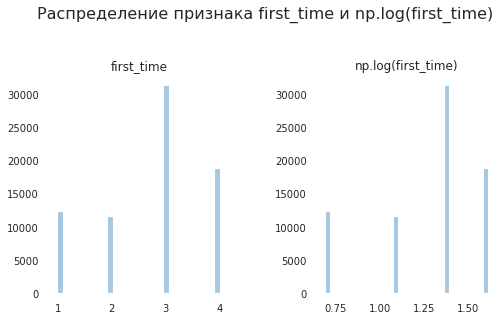

In [305]:
plot_dist_log(df[df.Train==1], 'first_time', figsize=(8,4))

**first_time** нормальное распределение смещено влево. Оставляем как есть.

## app_date

In [306]:
# Преобразуем признак в дату
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [307]:
# Посмотрим на максимальное и минимальное значение
start_date = df.app_date.min()
end_date = df.app_date.max()

print(start_date, end_date)

2014-01-01 00:00:00 2014-04-30 00:00:00


In [308]:
# Создадим новый признак - номер дня от минимальной даты
df['days_between_firstdate'] = (df.app_date - start_date).dt.days.astype('int')

Посмотрим как меняется распределение по дням в зависимости от дефолта

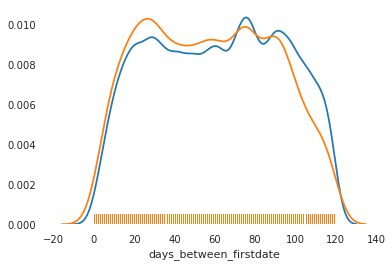

In [309]:
train_df = df[(df.Train==1)]
sns.distplot(train_df[train_df.default==0].days_between_firstdate, hist=False, rug=True)
sns.distplot(train_df[train_df.default==1].days_between_firstdate, hist=False, rug=True)

Из графика видно, что примерно с 90 дня банк стал лучше справляться с несостоятельными клиентами. Попробуем из этого предположения создать новый бинарный признак.

In [310]:
df['default_peak'] = (df.days_between_firstdate > 90).astype('int')

Посмотрим распределение дефолта по регионам

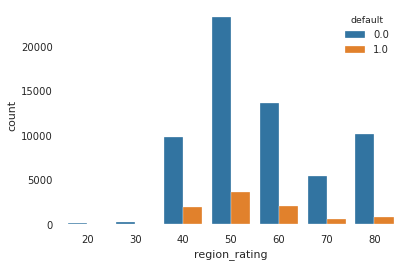

In [377]:
train_df = df[(df.Train==1)]
sns.countplot(x="region_rating", hue="default", data=train_df)

## Бинарные признаки 'sex', 'car', 'car_type', 'good_work', 'foreign_passport'

Данные признаки содержат всего по два значения, поэтому в будущем просто закодируем их через LabelEncoder

## Посмотрим на корреляцию признаков

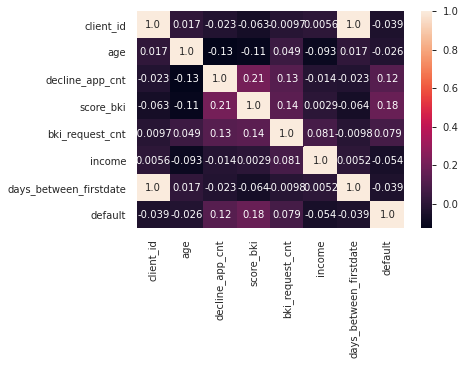

In [311]:
sns.heatmap(train_df[num_cols+['default']].corr(), annot=True, fmt='.2')

Как видим особой корреляции между признакими нету, поэтому оставляем все в работе.

## Значимость переменных по ANOVA F-Test

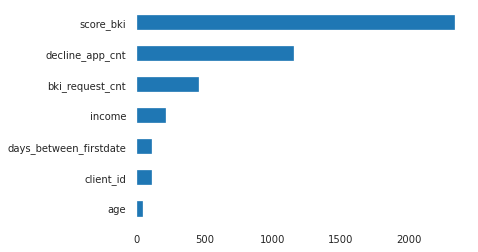

In [312]:
plot_fclassif(train_df, num_cols, 'default')

Из f-теста видим, что основной акцент при работе над новыми признаками следует уделить score_bki, decline_app_cnt и bki_request_cnt.

## Значимость категориальных переменных

In [313]:
labelEncoder = LabelEncoder()

# Закодируем бинарные признаки
for column in bin_cols:
    df[column] = labelEncoder.fit_transform(df[column])
    
# Закодируем признак education, но сперва заполним пропуски самым частым значением
df.education = df.education.fillna('SCH')
df.education = labelEncoder.fit_transform(df.education)

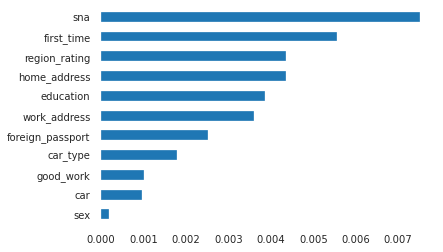

In [314]:
plot_mutual_info_classif(df[df.Train==1], bin_cols+cat_cols, 'default')

Видим, что сильная взаимная информация между таргетом и признаками sna, first_time, region_rating и home_address. Это знание поможет нам в feature engineering.

## Посмотрим на выбросы

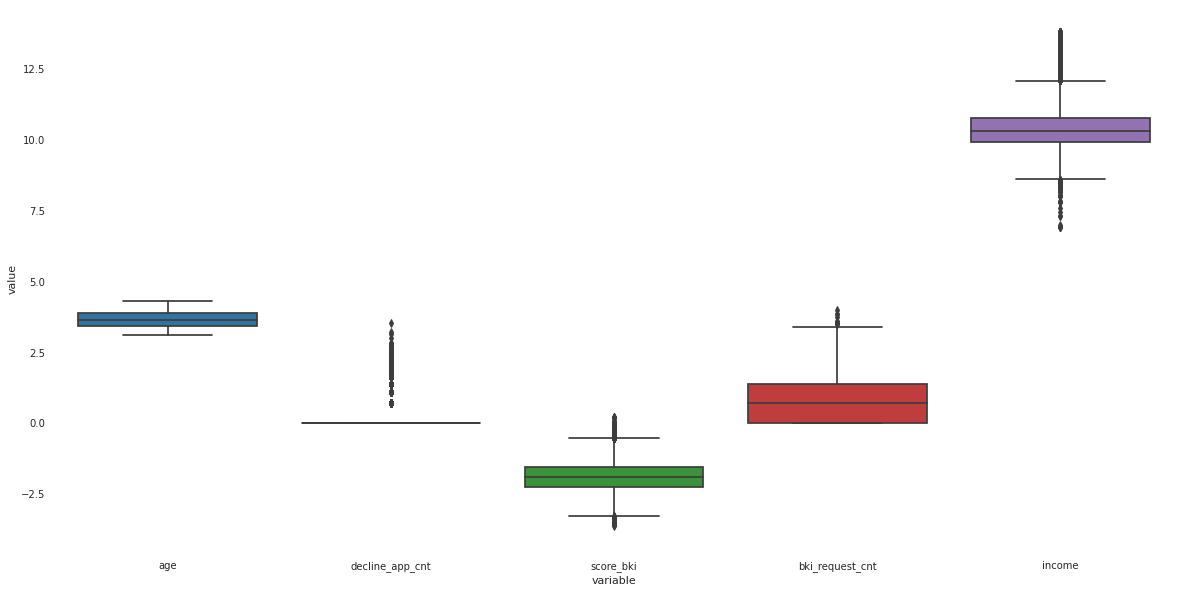

In [315]:
train_df = df[df.Train==1]
plot_outliers(train_df[num_cols[1:6]])

Видим, что присутствует достаточное количество выбросов в наших признаках. Попробуем обучить модель с ними, а дальше будет видно.

# 5. Обработка данных

In [316]:
# Категориальные признаки
df = pd.get_dummies(df, columns=cat_cols)

In [317]:
# Выполним нормализацию данных
rs = RobustScaler() # Используем робастный нормализатор, т.к. он устойчив к выбросам

df[num_cols] = rs.fit_transform(df[num_cols])

In [318]:
# Посмотрим еще раз на наши данные
df.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,default,Train,days_between_firstdate,default_peak,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,-0.529647,2014-02-01,1,1.104220,1,1,0.000000,0,-0.126966,0.000000,-0.583482,0,0.0,1,-0.553571,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,0.146831,2014-03-12,0,0.997653,0,0,0.000000,0,0.561041,0.500000,-0.521725,0,0.0,1,0.142857,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0
2,-0.529974,2014-02-01,1,-0.828882,1,0,1.098612,0,0.740284,0.000000,0.000000,1,0.0,1,-0.553571,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1
3,-0.705466,2014-01-23,0,0.767524,0,0,0.000000,0,-0.197313,0.292481,-1.254850,0,0.0,1,-0.714286,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,0.845788,2014-04-18,1,0.555299,0,0,0.000000,1,0.976254,0.000000,0.000000,1,0.0,1,0.803571,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1


In [319]:
# Удаляем лишние признаки
df.drop(['app_date'], axis=1, inplace=True)

# 6. Построение модели

In [320]:
# Готовим данные для обучения модели
train_data = df[df.Train == 1].drop(['Train'], axis=1)
test_data = df[df.Train == 0].drop(['Train'], axis=1)

y = train_data.default.values
X = train_data.drop(['default'], axis=1)

In [321]:
# Разбиваем нашу выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Выполняем обучение модели

In [322]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=500)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]


## Проводим оценку модели

In [323]:
show_model_metrics(y_test, y_pred, y_pred_prob)

f1_score: 0.04444444444444444
precision_score: 0.39814814814814814
recall_score: 0.02353585112205802
roc_auc: 0.7449656646898666


## ROC кривая

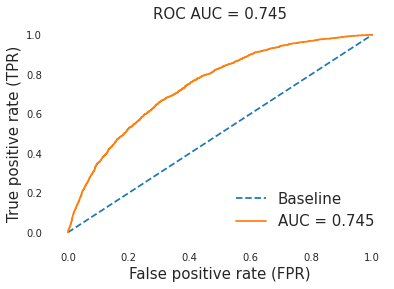

In [324]:
roc_auc_plot(y_test, y_pred_prob)

## Матрица ошибок

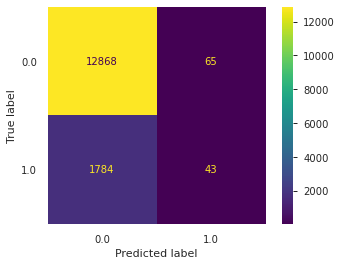

In [325]:
plot_confusion_matrix(model, X_test, y_test, values_format='d')

Как видим наша модель очень плохо предсказывает дефолтных клиентов из-за сильной несбалансированности нашей выборки. Хотя ROC-AUC показывает достаточно высокое значение, наша  модель выдает очень большую ошибку второго рода. С этим нужно что-то делать. По f1_score можно заметить, что модель несправляется с задачей. Посмотрим еще на одну метрику PRC-AUC, которая поможет оценить алгоритм на несбалансированных данных.

## Precision-Recall кривая

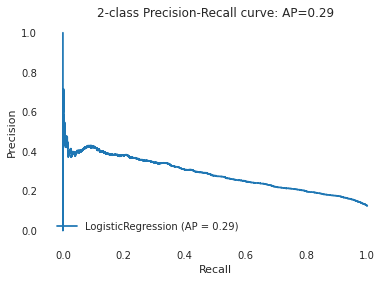

In [326]:
plot_prc_auc(model, X_test, y_test, y_pred_prob)

## Кросс-валидация

In [327]:
validate = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)

0.7403857593422012


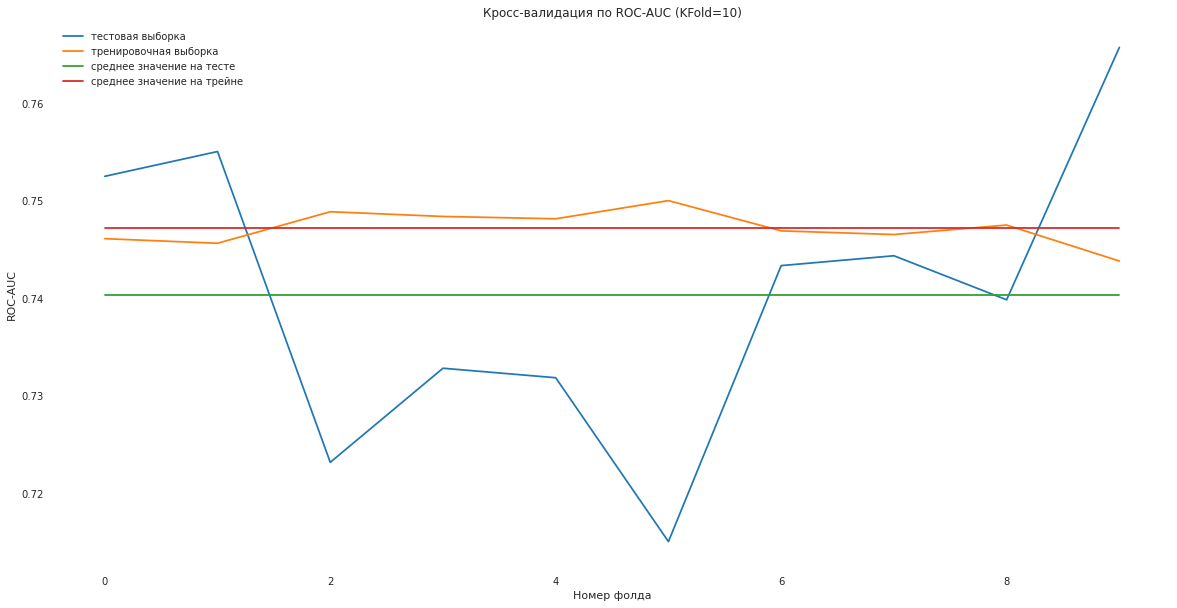

In [328]:
plot_crossval_score(validate, 'ROC-AUC')
print(np.mean(validate['test_score']))

Полученная модель показывает плохие результаты, хотя метрика ROC-AUC имеет достаточно высокое значение (0.745).
По матрице ошибок видно,что мы предсказали всего **43** дефолтных клиента из **1784**, что принесет банку убытки, потому что наша модель будет одобрять кредиты клиентам, которые не смогут их вернуть.
По PR-AUC видно, что качество нашей модели достаточно низкое.

Как видим, при кросс-валидаций на 10 фолдах ROC-AUC достаточно стабилен. Имеется небольшой провал на обучающей выборке. Далее попробуем подобрать параметры модели и посмотреть на результат.

## Поиск оптимальных параметров модели

In [329]:
# Используем GridSearchCV для поиска оптимальных параметров модели
# model = LogisticRegression(random_state=RANDOM_SEED)

# iter_ = 500
# epsilon_stop = 1e-3
# C = np.arange(0, 1, 10)

# param_grid = [
#     {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'C': C,
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'C': C,
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]
# gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
# gridsearch.fit(X_train, y_train)
# model = gridsearch.best_estimator_
# # Выведем параметры
# best_parameters = model.get_params()
# for param_name in sorted(best_parameters.keys()):
#         print('\t%s: %r' % (param_name, best_parameters[param_name]))
# # Выведем метрики
# preds = model.predict(X_test)
# print('Accuracy: %.4f' % accuracy_score(y_test, preds))
# print('Precision: %.4f' % precision_score(y_test, preds))
# print('Recall: %.4f' % recall_score(y_test, preds))
# print('F1: %.4f' % f1_score(y_test, preds))

На подобранных параметрах непохо подросла метрика f1_score. Попробуем обучить модель с новыми параметрами.

## Вторая модель с подобранными параметрами

In [330]:
X_train, X_test, y_train, y_test = prepare_data(df)

model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'none', 
                           solver = 'sag',
                           max_iter = 500,
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

## Оценим качество второй модели

In [331]:
show_model_metrics(y_test, y_pred, y_pred_prob)
validate = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
print(np.mean(validate['test_score']))

f1_score: 0.3402286336418073
precision_score: 0.22640825937330195
recall_score: 0.6841817186644773
roc_auc: 0.7445720737220429
0.740441822263344


Посмотрим на матрицу ошибок.

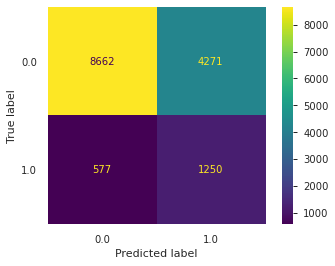

In [332]:
plot_confusion_matrix(model, X_test, y_test, values_format='d')

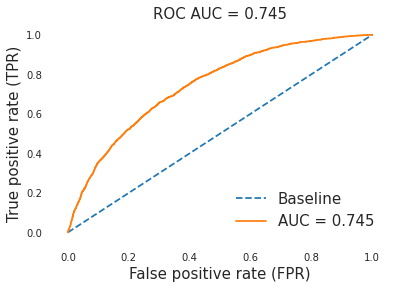

In [333]:
roc_auc_plot(y_test, y_pred_prob)

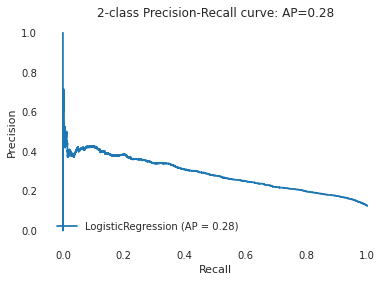

In [334]:
plot_prc_auc(model, X_test, y_test, y_pred_prob)

# Попробуем разные Pipeline

# preprocessing->Different classifiers

In [430]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

df = load_data(preprocess=False, drop_outliers=False, outliers_column='income', log_numerical=True)

# Разобьем данные
X_train, X_test, y_train, y_test = prepare_data(df)

# Модель 1
lr0 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'none', 
                           solver = 'sag',
                           max_iter = 500,
                           verbose= 0, 
                           warm_start= False)

# Модель 2
lr1 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.5, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'lbfgs',
                           max_iter = 500,
                           verbose= 0, 
                           warm_start= False)

# Предобработка данных
preprocessing = prepare_data_pipeline(scaler='robust', polynomial_features=False, polynomial_n=3)

# # Воспользуемся RandomizedSearchCV для более быстрого подбора параметров модели
# # Количество деревьев
# n_estimators = np.arange(200, 1000, 200)
# # Количество фич
# max_features = ['auto', 'sqrt']
# # Глубина дерева
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Минимальное количество сэмплов для сплита
# min_samples_split = [2, 5, 10]
# # Минимальное количество сэмплов в листе
# min_samples_leaf = [1, 2, 4]
# # Метод выбора сэмплов
# bootstrap = [True, False]

# # Рандомная сетка подбора параметров для деревьев
# random_grid_tree = {
#                        'max_features': max_features,
#                        'max_depth': max_depth,
#                        'min_samples_split': min_samples_split,
#                        'min_samples_leaf': min_samples_leaf,
#                        'bootstrap': bootstrap}

# parameters = { 'tree': {
#                             'decisiontreeclassifier__max_features': max_features,
#                             'decisiontreeclassifier__min_samples_split': min_samples_split,
#                             'decisiontreeclassifier__min_samples_leaf': min_samples_leaf,
#                             'decisiontreeclassifier__max_depth': max_depth,
#                         },
#                 'forest': {
#                             'randomforestclassifier__max_features': max_features,
#                             'randomforestclassifier__min_samples_split': min_samples_split,
#                             'randomforestclassifier__min_samples_leaf': min_samples_leaf,
#                             'randomforestclassifier__bootstrap': bootstrap,
#                             'randomforestclassifier__max_depth': max_depth,
#                             #'randomforestclassifier__n_estimators': n_estimators,
#                         },
#                 'gbc':  {
#                             'gradientboostingclassifier__max_features': max_features,
#                             'gradientboostingclassifier__min_samples_split': min_samples_split,
#                             'gradientboostingclassifier__min_samples_leaf': min_samples_leaf,
#                             'gradientboostingclassifier__max_depth': max_depth,
#                             #'gradientboostingclassifier__n_estimators': n_estimators,
#                         },
#                  'xgb': {
#                             'xgbclassifier__min_child_weight': [1, 5, 10],
#                             'xgbclassifier__gamma': [0.5, 1, 1.5, 2, 5],
#                             'xgbclassifier__subsample': [0.6, 0.8, 1.0],
#                             'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
#                             'xgbclassifier__max_depth': [3, 4, 5, 10]
#                  },
#                  'ada': {
#                              'adaboostclassifier__n_estimators':[500, 1000, 1500, 2000], 
#                              'adaboostclassifier__learning_rate':[0.05, 0.1, 0.15, 0.2]
#                  }
# }


# # Подбор параметров для Tree-based алгоритмов
# tree_classifiers = [
#     #{ 'classifier': DecisionTreeClassifier(), 'type': 'tree'}, { 'classifier': RandomForestClassifier(), 'type': 'forest' },
#     #{ 'classifier': GradientBoostingClassifier(), 'type': 'gbc'},
#     #{ 'classifier': XGBClassifier(), 'type': 'xgb'},
#     { 'classifier': AdaBoostClassifier(), 'type': 'ada'},
# ]

# best_params = []

# for tree in tree_classifiers:
#     pipe = make_pipeline(preprocessing, tree['classifier'])
#     rcv = RandomizedSearchCV(pipe, parameters[tree['type']], cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)
    
#     print(f'Fitting: {tree}')
#     rcv.fit(X_train, y_train)
    
#     best_params.append({'clf': tree['classifier'], 'best_params': rcv.best_params_, 'best_score': rcv.best_score_})
#     print(best_params)

# print(f'Best params: {best_params}')

# Переберем разные классификаторы и посмотрим на результат
classifiers = [
    lr0,
    lr1,
    SGDClassifier(loss='log'),
    #KNeighborsClassifier(), - медленная работа и плохой результат
    DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=10),
    RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features='auto', max_depth=10, bootstrap=True),
    AdaBoostClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100),
    XGBClassifier(verbose=False, objective='reg:logistic', n_estimators=100, subsample=1.0, min_child_weight=1, max_depth=4, gamma=5, colsample_bytree=1.0),
    LGBMClassifier(),
    CatBoostClassifier(verbose=False),
    ]

best_score = 0
best_model = 0
best_estimator = []

# Проводим поиск лучшего классификатора
for classifier in classifiers:
    pipe = make_pipeline(preprocessing, classifier)

    print('\n')
    print(f'Fitting {classifier}...')
    pipe.fit(X_train, y_train)
    print(f'Predicting...')
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:, 1]
    
    score = roc_auc_score(y_test, proba)
    print(f'ROC-AUC score is: {score}')
    
    if score > best_score:
        best_score = score
        best_model = classifier
        best_estimator.append([best_score, best_model, pipe])

print(f'Best model is: {best_model} with score: {best_score}')




Fitting LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='none',
                   random_state=42, solver='sag')...
Predicting...
ROC-AUC score is: 0.744460217708284


Fitting LogisticRegression(C=1.5, class_weight='balanced', max_iter=500,
                   random_state=42)...
Predicting...
ROC-AUC score is: 0.7445692804958197
Best model is: LogisticRegression(C=1.5, class_weight='balanced', max_iter=500,
                   random_state=42) with score: 0.7445692804958197


0.7407424967561965


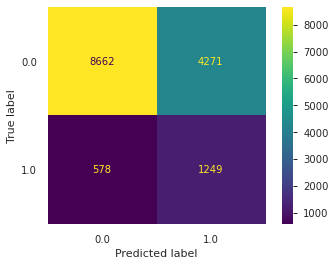

In [431]:
val_pipe = make_pipeline(preprocessing, lr1)
validate = cross_validate(val_pipe, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
print(np.mean(validate['test_score']))
val_pipe.fit(X_train, y_train)
plot_confusion_matrix(val_pipe, X_test, y_test, values_format='d')

In [446]:
get_top_abs_correlations(df.select_dtypes(include=['float64', 'int64']), 10)

client_id               days_between_firstdate    0.999581
score_bki               mean_region_bki           0.999420
home_address            work_address              0.726535
client_id               default_peak              0.725783
days_between_firstdate  default_peak              0.721774
sna                     first_time                0.526594
region_rating           income                    0.313187
                        work_address              0.254062
                        home_address              0.232971
home_address            default_peak              0.222132
dtype: float64

Из всех классификаторов лучший результат по метрике roc_auc показывает наша LogisticRegression. Ближе всех по результатам приближаются AdaBoostClassifier и GradientBoostingClassifier. Можно дополнительно попробовать беггинг логистической регрессии раз она показывает лучшие результаты.

Подбор параметров показал, что лучший результат получается, когда в пайплайн добавляем метод главных компонент с количеством признаков 25, но Kaggle говорит нам о другом и результат при использовании PCA падает :(

# Бэггинг логистической регрессии

In [423]:
from sklearn.ensemble import BaggingClassifier

df = load_data(preprocess=False, drop_outliers=False, outliers_column='income')

# Разобьем данные
X_train, X_test, y_train, y_test = prepare_data(df)

# Посчитаем веса классов
y0 = len(y_train[y_train == 1])
y1 = len(y_train[y_train == 0])

w0 = y1/y0
w1 = 1

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = w0
sample_weights[y_train == 1] = w1

lr = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.5, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'lbfgs',
                           max_iter = 500,
                           verbose= 0, 
                           warm_start= False)

# Предобработка данных
preprocessing = prepare_data_pipeline()

# Модель
model = BaggingClassifier(lr, 
                      n_estimators=5, 
                      bootstrap = True, random_state = RANDOM_SEED)

pipe = make_pipeline(preprocessing, model)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:, 1]
    
score = roc_auc_score(y_test, proba)

print(f'Model score: {score}')


Model score: 0.744363343544268


0.740267722796373


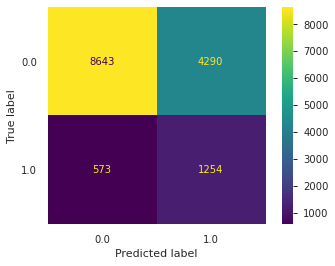

In [424]:
val_pipe = make_pipeline(preprocessing, model)
validate = cross_validate(val_pipe, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True)
print(np.mean(validate['test_score']))
val_pipe.fit(X_train, y_train)
plot_confusion_matrix(val_pipe, X_test, y_test, values_format='d')

Чуда не произошло - ансамбль логистических регрессий результат не улучшил.

# Submission

In [418]:
df = load_data(preprocess=False, drop_outliers=False, outliers_column='income', log_numerical=True)

train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

df_test = pd.read_csv(PATH_to_file+'test.csv')

In [419]:
# Удалим выбросы по income
#train_data = remove_outliers_iqr_column(train_data, 'income')

X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [420]:
# Наша лучшая модель
lr = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.5, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'lbfgs',
                           max_iter = 500,
                           verbose= 0, 
                           warm_start= False)

# Предобработка данных
preprocessing = prepare_data_pipeline(scaler='robust')

model = BaggingClassifier(lr, 
                      n_estimators=15, 
                      bootstrap = True, random_state = RANDOM_SEED)

best_pipe = make_pipeline(preprocessing, model)

best_pipe.fit(X_train, y_train)

y_pred_prob = best_pipe.predict_proba(X_test)[:,1]
y_pred = best_pipe.predict(X_test)

In [421]:
y_pred_prob = best_pipe.predict_proba(X_test)[:,1]

submit = pd.DataFrame(test_data.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission2.csv', index=False)


**Вывод:** Удалось добиться результата метрики: **0.73766**
Данный датасет показал лучшие результаты на логистической регрессии с подобранными GridSearchCV гиперпараметрами. Что не успел: Проверить автоматический фичаинжениринг через featuretools и найти скрытые инсайты.